In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from functools import reduce  
import matplotlib.pyplot as plt


In [2]:
p = 7
n = 10
min_cor = 0
max_cor = 0.1

true_betas = np.array([0,1,2,3,4,5,6])

In [3]:
def get_sim_data(p, n, min_cor, max_cor, true_betas):
    
    sd_vec = np.ones(p) 
    mean = np.zeros(p)
    cor_matrix = np.zeros((p,p))

    correlation = np.random.uniform(min_cor, max_cor, int(p * (p - 1) / 2))
    cor_matrix[np.triu_indices(p, 1)] = correlation
    cor_matrix[np.tril_indices(p, -1)] = cor_matrix.T[np.tril_indices(p, -1)]
    np.fill_diagonal(cor_matrix, 1)


    D = np.diag(sd_vec)
    sigma = D.dot(cor_matrix).dot(D)

    X = np.random.multivariate_normal(mean, sigma, n)
    eps = np.random.normal(0, 1, n)

    y = X.dot(true_betas) + eps 
    
    y = pd.Series(y, name = "y")
    
    column_names = []
    
    for value in range(1, p + 1): 
        
        column = f"X_{value}"
        column_names.append(column)
        
    
    X = pd.DataFrame(X, columns = column_names)
    
    df = pd.concat([y, X], axis = 1)
    
    return y, X, df



In [4]:
y, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas)

In [5]:
df

,y,X_1,X_2,X_3,X_4,X_5,X_6,X_7
0,-21.223908,-1.040402,0.068390,-0.448062,-0.688484,-0.677871,-0.431523,-2.185508
1,-4.315797,-0.359804,1.195163,-0.216170,0.857428,0.746258,-1.029831,-1.046512
2,-14.351190,-1.356446,-0.091376,0.828013,-0.018790,-2.685207,-0.403997,-0.434859
3,15.951538,1.079083,0.819908,2.227597,-0.273862,-0.508535,0.386343,1.958695
4,-10.919555,0.885132,0.069146,-1.592169,-2.664625,-0.254892,1.830109,-1.044708
5,15.986943,0.822815,0.326915,0.273323,2.521996,0.685237,-0.983295,2.088618
6,5.073000,0.036420,-0.882971,0.872998,1.070057,0.212234,-1.947348,1.436168
7,2.140988,-0.496246,0.133131,-0.304442,0.715905,-0.196152,1.216512,-1.118837
8,-5.374881,0.268840,0.552332,-1.113724,1.130995,-1.101168,-0.836147,0.157427
9,-11.910810,-0.027749,0.438805,-0.161080,0.423814,1.359912,-2.107739,-1.566437


In [6]:
reg = LinearRegression().fit(X, y)

In [7]:
reg.coef_


array([ 1.84018991, -0.08561005,  3.1959391 ,  3.99071483,  3.54558381,
        4.96742956,  4.11229359])

In [8]:
"""Zero multicollinearity.
   n = 30; p = 2, 28, 30, 35. 
"""
np.random.seed(123)

n_sim = 30
p_sim = np.array([2, 28, 30, 35])
dataframes = len(p_sim)
min_corr_sim = 0
max_corr_sim = 0 
iterations_sim = 500

matrix_betas_final = []
matrix_betas_mean = []
matrix_bias_sq = []
matrix_betas_var_mean = []
matrix_betas_var_final = []


for m in range(dataframes): 
    
    
    for p in p_sim: 
    
        matrix_var = []
        matrix_betas = []
    
        for i in range(iterations_sim):
    
            true_betas_sim = np.repeat(5, p)
    
            y, X, df = get_sim_data(p, n_sim, min_corr_sim, max_corr_sim, true_betas_sim) 
    
            var_cov = np.linalg.inv(np.dot(X.T, X))
            var_betas = var_cov.diagonal() 
        
            #reg = LinearRegression().fit(X, y)
            betas = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        
            #matrix_betas.append(reg.coef_)
            matrix_betas.append(betas)
        
            matrix_var.append(var_betas)
        
            X_names = []
            beta_names = []
    
            for value in range(1, p + 1): 
            
                column_X = f"X_{value}"
                column_betas = f"beta_{value}"
                X_names.append(column_X)
                beta_names.append(column_betas)
        
            df_var = pd.DataFrame(matrix_var, columns = X_names)
            df_betas = pd.DataFrame(matrix_betas, columns = beta_names) 
        
            bias_squared = (df_betas.mean() - true_betas_sim)**2
        
        matrix_betas_final.append(df_betas)
        matrix_betas_mean.append(df_betas.mean())
        matrix_bias_sq.append(bias_squared)
        matrix_betas_var_mean.append(df_var.mean())
        matrix_betas_var_final.append(df_var)
    
 

In [9]:
matrix_betas_var_mean[0]
matrix_betas_var_mean[1]
matrix_betas_var_mean[2]
matrix_betas_var_mean[3]

X_1    -2.766848e+13
X_2    -3.320289e+13
X_3     3.246389e+13
X_4     6.095380e+12
X_5    -2.690809e+13
X_6    -3.741737e+13
X_7    -2.049798e+13
X_8    -4.448690e+13
X_9    -1.379433e+13
X_10   -2.104500e+13
X_11    1.082571e+13
X_12    2.780041e+12
X_13    9.565688e+11
X_14   -2.279610e+12
X_15    4.250038e+13
X_16    6.405215e+12
X_17   -1.033276e+13
X_18   -4.202050e+13
X_19   -1.930038e+13
X_20   -2.906674e+13
X_21    2.711959e+13
X_22    1.142487e+13
X_23   -9.667820e+13
X_24   -3.028840e+12
X_25   -3.052798e+13
X_26   -1.196195e+13
X_27    1.181959e+13
X_28   -2.375272e+13
X_29   -5.396132e+13
X_30   -1.359054e+13
X_31   -3.697549e+13
X_32   -1.530770e+13
X_33    6.374014e+12
X_34   -1.058066e+13
X_35    4.707655e+12
dtype: float64

## Standardize data set before performing ridge. 


In [61]:
def iterate_ridge(n, p, min_cor, max_cor, iterations_sim, true_betas, alphas):
    
    beta_var_names = []
    ridge_beta_names = []
    
    for value in range(1, p + 1): 
    
        column_betas_var = f"beta_var_{value}"
        column_betas = f"beta_{value}"
        beta_var_names.append(column_betas_var)
        ridge_beta_names.append(column_betas)

    df_list_betas_ridge = []
    df_list_var_ridge = []

    for i in range(iterations_sim):
        
        true_betas_sim = true_betas
    
        y, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas_sim) 
        
        i, k = X.shape
        I = np.identity(k)
    
        matr_var = []
        matr_beta = []
    

        for a in alphas: 
        
            ridge_beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), X.T), y)
            matr_beta.append(ridge_beta)
            df_ridge_betas = pd.DataFrame(matr_beta, columns = ridge_beta_names)
        
            ridge_var_cov = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), np.dot(X.T, X)), np.linalg.inv(np.dot(X.T, X) + a * I))
            ridge_var = ridge_var_cov.diagonal()
            matr_var.append(ridge_var)
            df_ridge_var = pd.DataFrame(matr_var, columns = beta_var_names)
        
         
        df_list_betas_ridge.append(df_ridge_betas)
        df_list_var_ridge.append(df_ridge_var)
        
    return df_list_betas_ridge, df_list_var_ridge



In [63]:
np.random.seed(20)

p_regressors = [2, 28, 30, 35]
n = 30
#true_betas = np.repeat(5, p)
min_cor = 0 
max_cor = 0 
iterations = 1

alphas = np.array([int(0), 0.00000000000000000001, 0.00000000000001, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 15, 20, 30, 50, 100, 120])


collect_ridge_betas = []
collect_ridge_var = []

for p in p_regressors: 
    
    ridge_betas, beta_var = iterate_ridge(n, p, min_cor, max_cor, iterations, np.repeat(5, p), alphas)
    collect_ridge_betas.append(ridge_betas)
    collect_ridge_var.append(beta_var)
    
    


In [65]:
collect_ridge_betas[1][0]

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28
0,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
1,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
2,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
3,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
4,5.562577,5.791018,5.988473,4.194157,6.194270,5.834036,5.239480,6.580478,3.945803,5.710266,...,5.926145,3.890836,5.754093,4.052451,4.317579,5.941543,6.190425,4.645697,4.257558,4.706767
5,5.562568,5.791001,5.988456,4.194170,6.194241,5.834017,5.239480,6.580444,3.945821,5.710253,...,5.926112,3.890854,5.754077,4.052476,4.317596,5.941533,6.190397,4.645702,4.257574,4.706779
6,5.562476,5.790830,5.988280,4.194307,6.193958,5.833829,5.239480,6.580106,3.945996,5.710123,...,5.925777,3.891043,5.753908,4.052724,4.317760,5.941427,6.190109,4.645749,4.257734,4.706900
7,5.561554,5.789128,5.986528,4.195669,6.191125,5.831947,5.239482,6.576732,3.947742,5.708822,...,5.922434,3.892923,5.752224,4.055202,4.319404,5.940370,6.187239,4.646216,4.259337,4.708108
8,5.552400,5.772289,5.969162,4.209170,6.163065,5.813299,5.239519,6.543305,3.965017,5.695956,...,5.889318,3.911531,5.735532,4.079727,4.335641,5.929891,6.158819,4.650839,4.275193,4.720059
9,5.466586,5.620077,5.810032,4.332668,5.906708,5.642026,5.241198,6.237534,4.120673,5.579524,...,5.587134,4.079886,5.582470,4.301698,4.479988,5.833167,5.899941,4.692051,4.418479,4.828234


In [66]:
def plot_ridge_regression(alphas, ridge_betas): 

    ax = plt.gca()
    
    ax.plot(alphas, ridge_betas)
    
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.rcParams["figure.figsize"] = (30,20)
    plt.xlabel("alpha", fontsize = 30)
    plt.ylabel("weights", fontsize = 30)
    
    ax.tick_params(axis='both', which='major', labelsize=25)

    plt.title("Ridge coefficients as a function of the regularization", fontsize = 35)
    plt.axis("tight")
    plt.show()



$$
V\left(\hat{\boldsymbol{\beta}}^{*}\right)=\sigma^{2}\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}\right)\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}.
$$

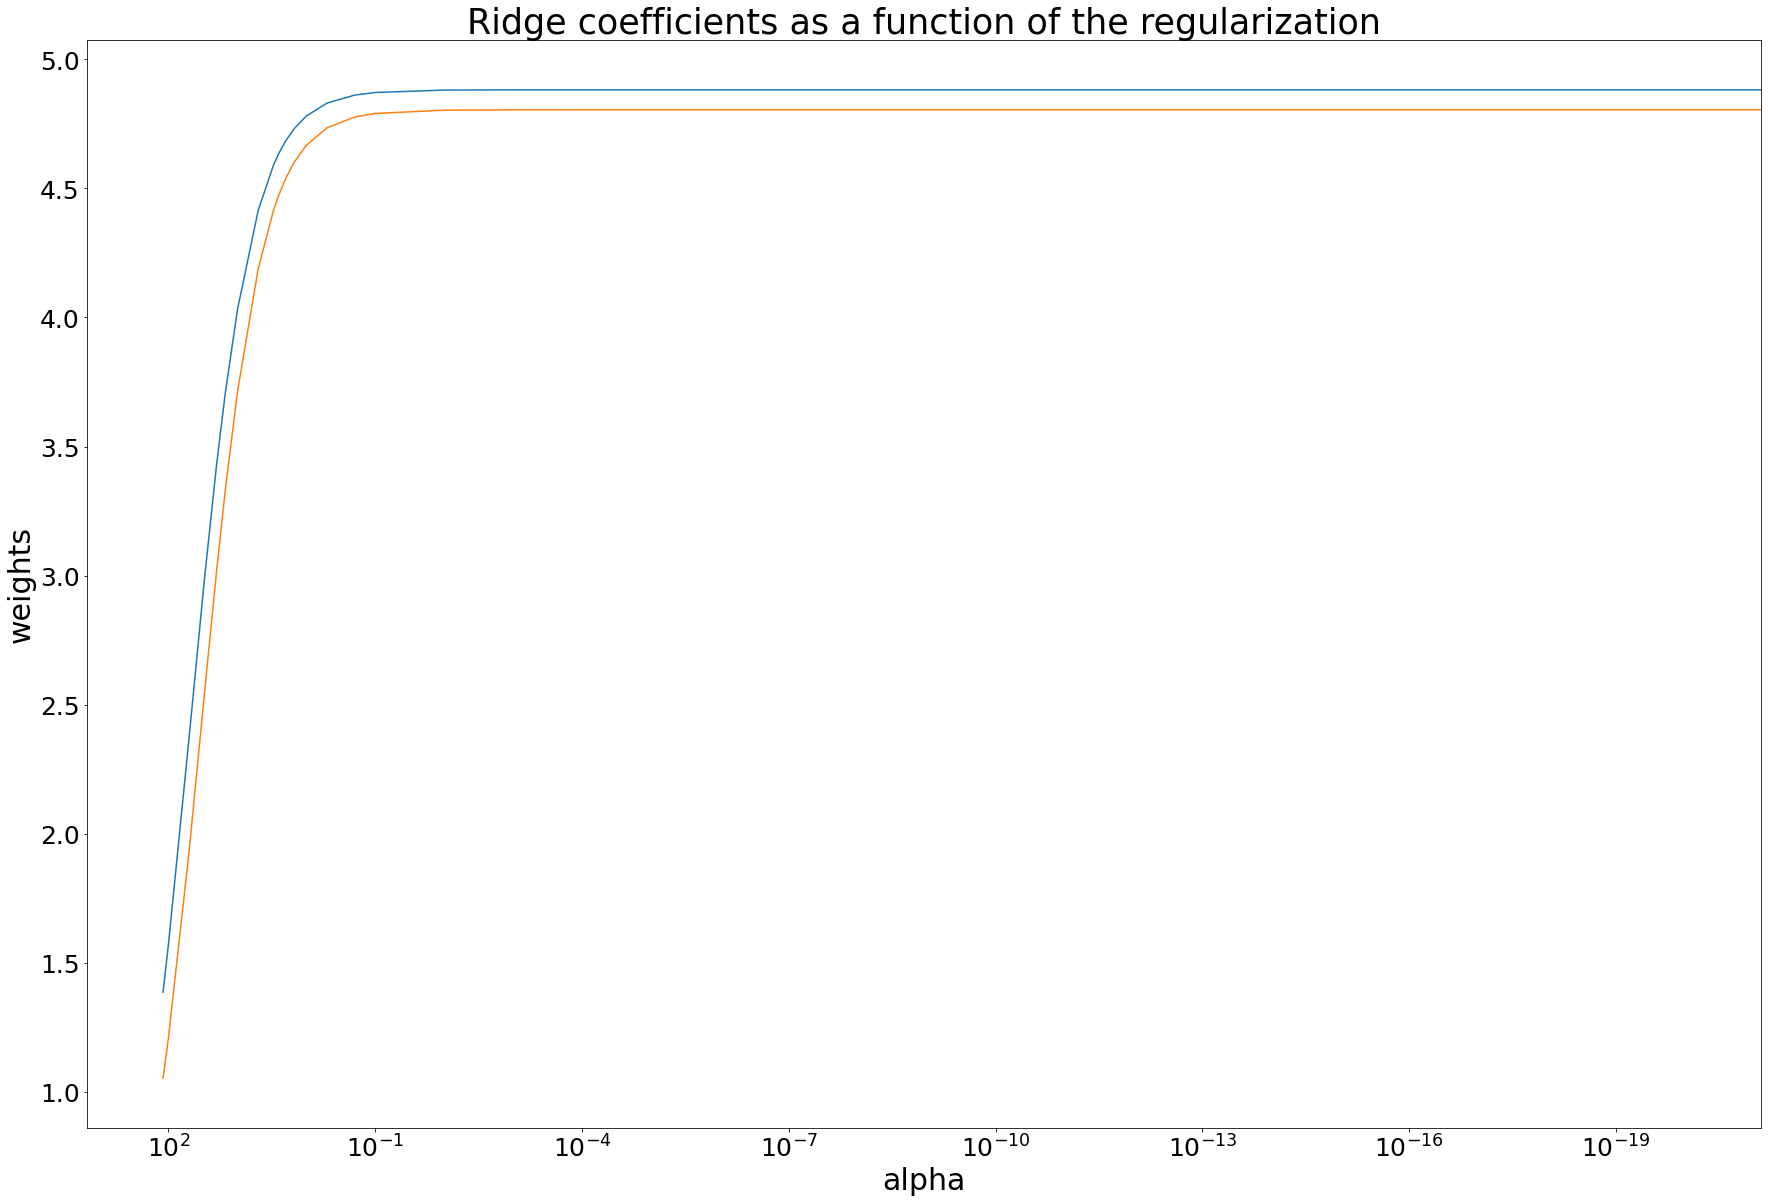

In [67]:
plot_ridge_regression(alphas, collect_ridge_betas[0][0])



In [32]:
np.random.seed(159)

n = 30
min_cor = 0 
max_cor = 0 
iterations_sim = 1000

alphas = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 15, 20]) 

df_list_betas_ridge_28, df_list_var_ridge_28 = iterate_ridge(n, 28, min_cor, max_cor, iterations_sim, alphas)

mean_df_list_betas_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_28) / iterations_sim
mean_df_list_var_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_28) / iterations_sim

mean_df_list_betas_ridge_28
mean_df_list_betas_ridge_28["alpha"] = alphas
mean_df_list_betas_ridge_28.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_28
    
mean_df_list_var_ridge_28
mean_df_list_var_ridge_28["alpha"] = alphas
mean_df_list_var_ridge_28.set_index("alpha", inplace = True)
mean_df_list_var_ridge_28


,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_19,beta_var_20,beta_var_21,beta_var_22,beta_var_23,beta_var_24,beta_var_25,beta_var_26,beta_var_27,beta_var_28
alpha,,,,,,,,,,,,,,,,,,,,,
0.0000,1.154005,1.033463,1.062281,1.111585,1.084819,0.958145,1.042437,1.168249,0.951037,1.296454,...,1.115764,0.904155,0.994906,0.839637,1.063106,1.135098,1.169798,1.056703,0.996447,1.119178
0.0001,1.100114,0.953279,1.022284,1.007266,1.049434,0.896664,1.007740,1.078787,0.906172,1.152591,...,1.043173,0.889406,0.943474,0.826919,0.998496,1.052282,1.116943,0.968449,0.946747,1.026294
0.0010,0.892618,0.794993,0.871567,0.815595,0.883702,0.754079,0.849070,0.874060,0.779029,0.869741,...,0.851059,0.813961,0.812549,0.763808,0.814682,0.870807,0.907771,0.785081,0.825085,0.827944
0.0100,0.581787,0.571574,0.575627,0.580926,0.591584,0.545168,0.570830,0.595492,0.541649,0.590786,...,0.586093,0.586231,0.576338,0.557858,0.558992,0.587665,0.597711,0.535393,0.602952,0.556083
0.1000,0.254459,0.256543,0.253728,0.260009,0.258808,0.251489,0.254843,0.260529,0.243953,0.259955,...,0.258837,0.262770,0.255727,0.253661,0.254087,0.259331,0.264323,0.245666,0.265345,0.247975
0.2000,0.183042,0.183705,0.183053,0.186465,0.184663,0.181898,0.184353,0.186707,0.176364,0.184869,...,0.185859,0.188607,0.184316,0.183080,0.182966,0.186808,0.188854,0.178430,0.188163,0.179142
0.5000,0.113836,0.113632,0.113953,0.115269,0.113985,0.113468,0.115294,0.115678,0.110617,0.113348,...,0.115851,0.116643,0.114617,0.114002,0.113309,0.115769,0.115896,0.111740,0.114975,0.111964
1.0000,0.077142,0.076889,0.077232,0.077909,0.077152,0.077046,0.078329,0.078244,0.075751,0.076450,...,0.078874,0.078779,0.077528,0.077196,0.076675,0.078118,0.077876,0.076013,0.077390,0.076240
2.0000,0.050767,0.050556,0.050776,0.051187,0.050801,0.050766,0.051509,0.051342,0.050386,0.050287,...,0.051985,0.051620,0.050857,0.050659,0.050515,0.051156,0.050898,0.050197,0.050771,0.050406


In [33]:
mean_df_list_betas_ridge_28

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28
alpha,,,,,,,,,,,,,,,,,,,,,
0.0000,4.941030,5.035232,5.007396,5.009905,5.047606,4.960237,4.990033,5.017430,4.953106,4.996454,...,5.006803,4.972181,5.023533,5.043405,5.006744,5.018984,5.010822,4.946738,4.969571,4.980167
0.0001,4.940963,5.030737,5.004771,5.013123,5.046450,4.963233,4.988924,5.013074,4.955772,4.992241,...,5.004644,4.970526,5.019716,5.043116,5.008282,5.015045,5.012202,4.942812,4.970877,4.976136
0.0010,4.943170,5.014794,4.994588,5.017401,5.037200,4.969602,4.982640,4.997662,4.962455,4.982163,...,4.998692,4.962076,5.004798,5.037254,5.008373,5.002904,5.013876,4.932077,4.969483,4.964714
0.0100,4.932687,4.970079,4.965387,4.992757,4.992072,4.951788,4.945893,4.955399,4.944836,4.959321,...,4.965176,4.929293,4.962652,4.993212,4.978232,4.974177,4.979879,4.917037,4.938882,4.940070
0.1000,4.791867,4.800376,4.820361,4.836439,4.819512,4.813092,4.774265,4.789776,4.796956,4.802702,...,4.790151,4.776720,4.810982,4.817297,4.825167,4.826267,4.811287,4.809076,4.784356,4.812649
0.2000,4.687969,4.690407,4.715439,4.727468,4.710705,4.712496,4.661181,4.678184,4.697011,4.695184,...,4.677594,4.671859,4.710009,4.709137,4.717050,4.719334,4.704645,4.719672,4.673846,4.724364
0.5000,4.480259,4.471342,4.503339,4.512738,4.497033,4.509773,4.440443,4.454399,4.501255,4.484238,...,4.452952,4.464081,4.507311,4.500184,4.498043,4.500057,4.495338,4.530578,4.447388,4.543654
1.0000,4.253290,4.231971,4.270224,4.279134,4.263956,4.287665,4.203153,4.210348,4.288233,4.257321,...,4.205151,4.236125,4.282598,4.274554,4.257621,4.257858,4.268150,4.316919,4.198317,4.340059
2.0000,3.949185,3.914882,3.958860,3.966833,3.952395,3.990698,3.889807,3.888169,4.001031,3.956328,...,3.873996,3.929668,3.977246,3.973605,3.937677,3.936145,3.966088,4.025734,3.869903,4.060526


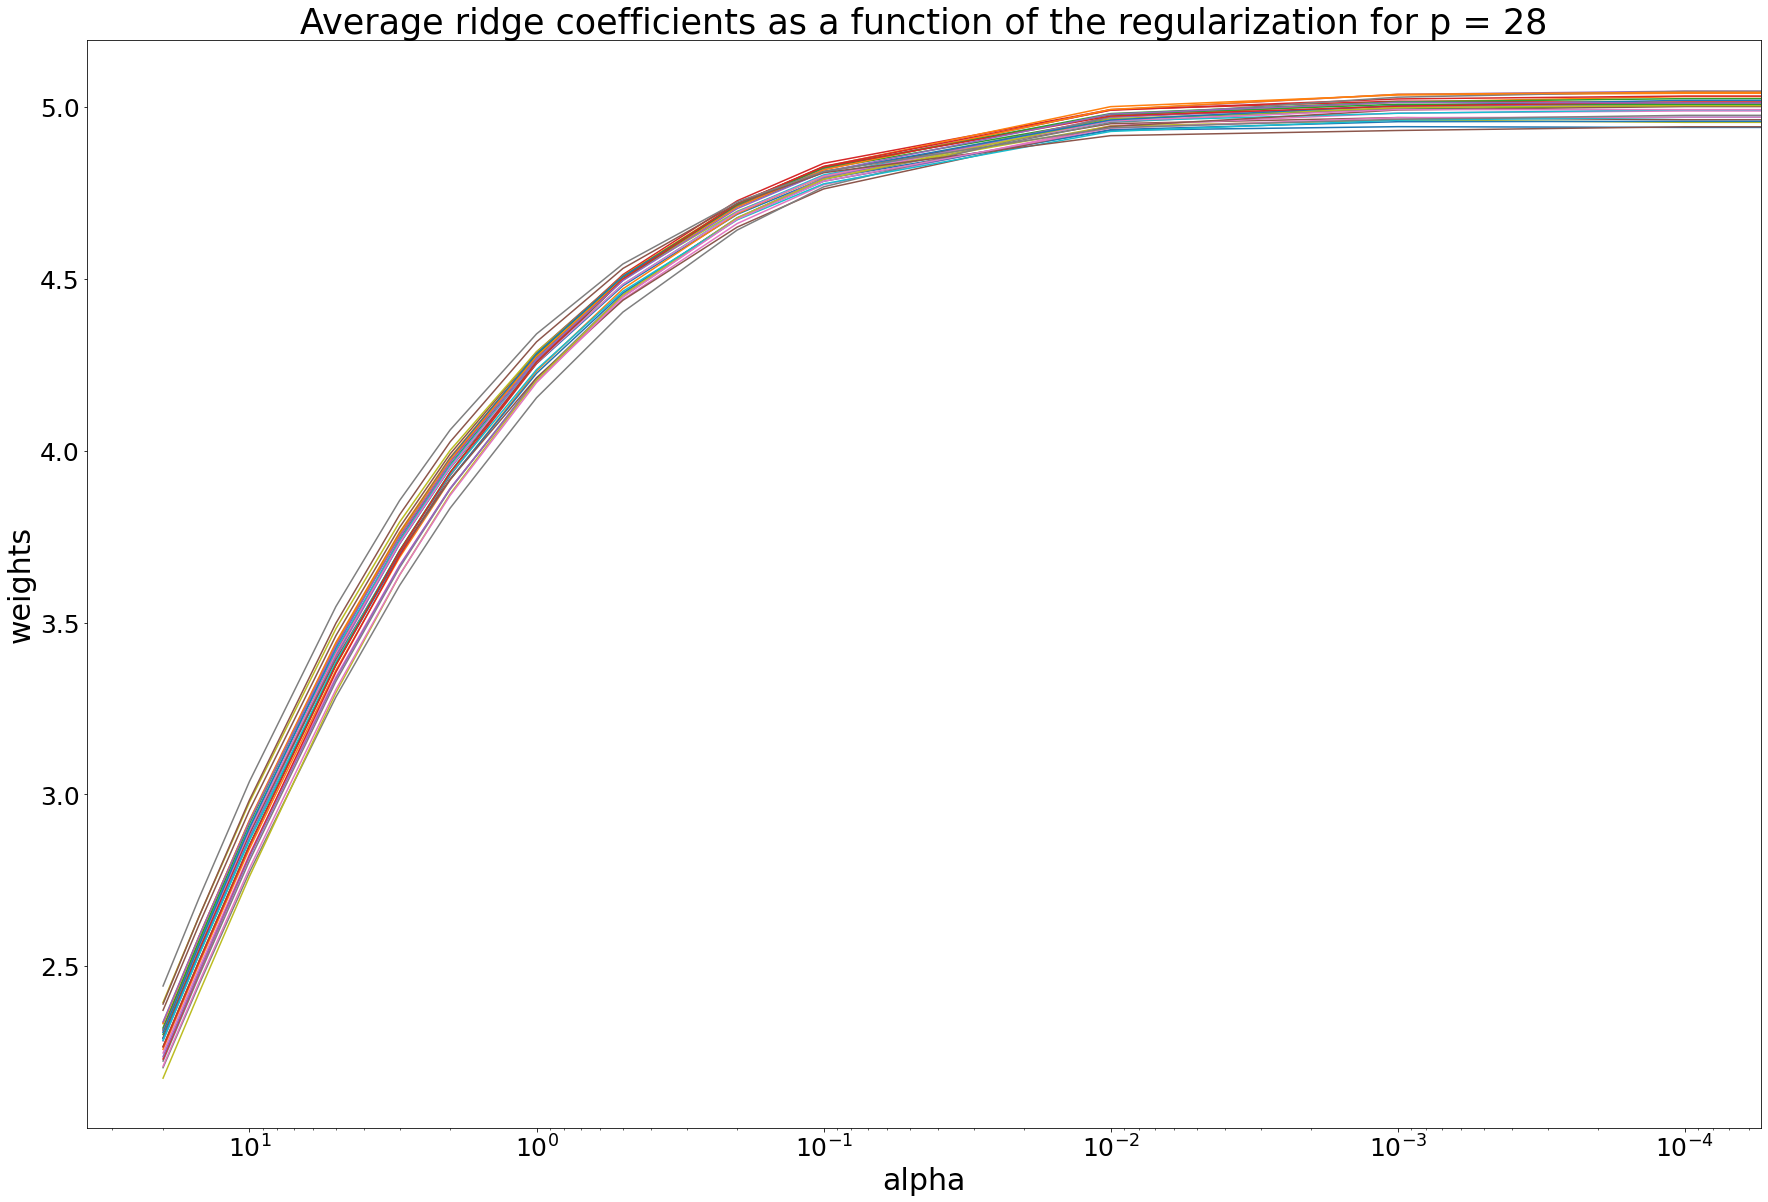

In [34]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_28)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 28", fontsize = 35)
plt.axis("tight")
plt.show()




In [35]:
df_list_betas_ridge_2, df_list_var_ridge_2 = iterate_ridge(n, 2, min_cor, max_cor, iterations_sim, alphas)

mean_df_list_betas_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_2) / iterations_sim
mean_df_list_var_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_2) / iterations_sim

mean_df_list_betas_ridge_2
mean_df_list_betas_ridge_2["alpha"] = alphas
mean_df_list_betas_ridge_2.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_2
    
mean_df_list_var_ridge_2
mean_df_list_var_ridge_2["alpha"] = alphas
mean_df_list_var_ridge_2.set_index("alpha", inplace = True)
mean_df_list_var_ridge_2

,beta_var_1,beta_var_2
alpha,,
0.0000,0.036871,0.036899
0.0001,0.036870,0.036899
0.0010,0.036868,0.036896
0.0100,0.036840,0.036869
0.1000,0.036569,0.036597
0.2000,0.036271,0.036298
0.5000,0.035402,0.035427
1.0000,0.034029,0.034050
2.0000,0.031533,0.031550


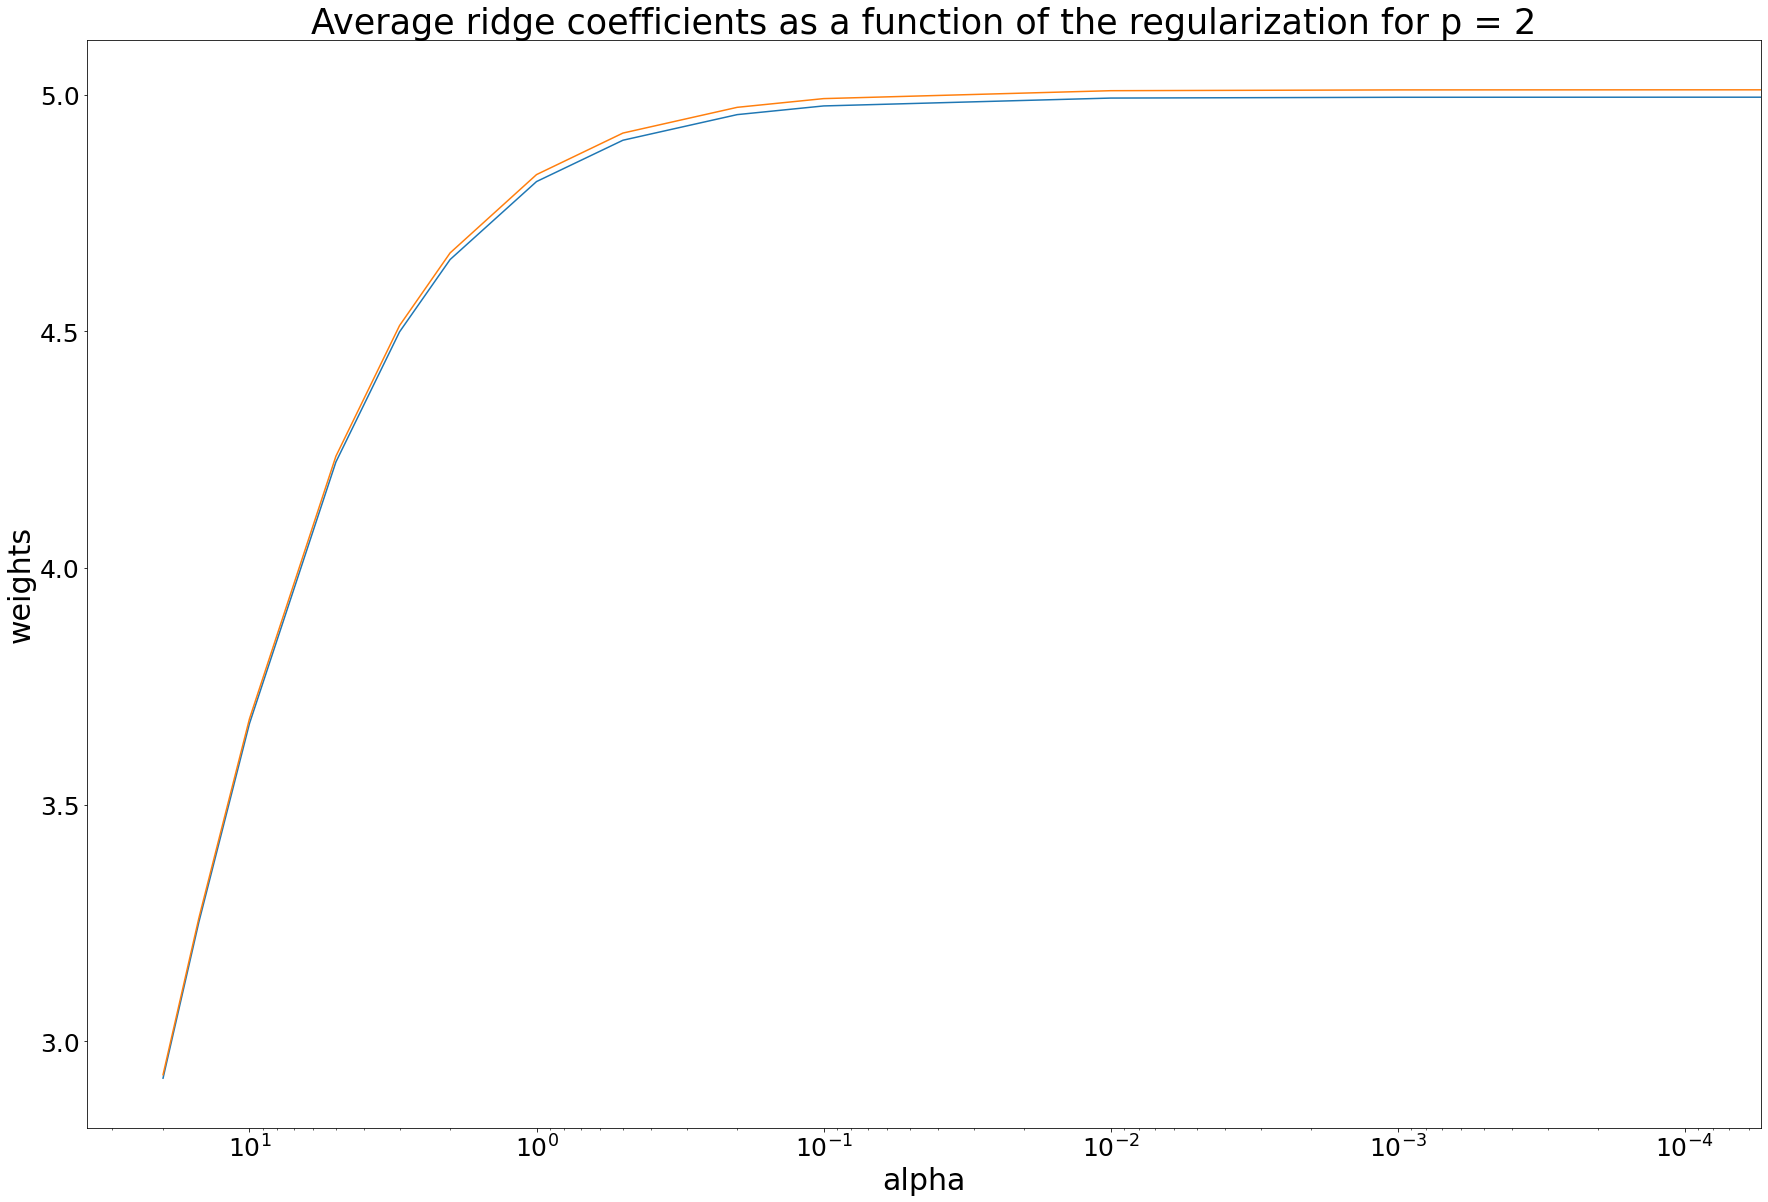

In [36]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_2)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 2", fontsize = 35)
plt.axis("tight")
plt.show()



In [37]:
df_list_betas_ridge_30, df_list_var_ridge_30 = iterate_ridge(n, 30, min_cor, max_cor, iterations_sim, alphas)

mean_df_list_betas_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_30) / iterations_sim
mean_df_list_var_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_30) / iterations_sim

mean_df_list_betas_ridge_30
mean_df_list_betas_ridge_30["alpha"] = alphas
mean_df_list_betas_ridge_30.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_30
    
mean_df_list_var_ridge_30
mean_df_list_var_ridge_30["alpha"] = alphas
mean_df_list_var_ridge_30.set_index("alpha", inplace = True)
mean_df_list_var_ridge_30

,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_21,beta_var_22,beta_var_23,beta_var_24,beta_var_25,beta_var_26,beta_var_27,beta_var_28,beta_var_29,beta_var_30
alpha,,,,,,,,,,,,,,,,,,,,,
0.0000,467.796082,234.895029,817.524288,997.720932,182.636992,192.800471,459.362609,263.346481,336.399323,195.283577,...,160.673113,315.619724,426.133187,130.069757,780.639376,266.638905,291.293375,258.103602,597.100837,626.077095
0.0001,13.771787,13.979961,12.443243,12.459851,11.454463,12.232146,12.416043,11.236773,14.384541,14.034122,...,12.156265,13.976649,13.795619,12.946380,13.225988,12.545183,13.059565,13.534423,12.048032,12.509674
0.0010,4.007267,3.835672,3.754677,3.802118,3.695125,3.851563,3.835720,3.568487,3.867944,3.676390,...,3.736217,4.088434,4.146397,3.854653,4.014914,3.680966,4.029242,4.124676,3.516817,3.828007
0.0100,1.026398,1.002355,0.993434,0.988476,1.009537,1.052634,1.033929,1.001962,0.994020,0.942755,...,1.037656,1.044462,1.036607,1.017997,1.069525,0.993171,1.048463,1.073778,1.002881,1.011936
0.1000,0.276458,0.271461,0.271840,0.269233,0.276647,0.279288,0.271913,0.280346,0.280091,0.270162,...,0.282172,0.273416,0.272900,0.280118,0.279389,0.277512,0.274370,0.273809,0.279333,0.275886
0.2000,0.189937,0.186086,0.186564,0.184581,0.188597,0.188396,0.184506,0.190835,0.191552,0.186237,...,0.191245,0.187025,0.186501,0.191000,0.189620,0.189759,0.186643,0.186415,0.190756,0.188798
0.5000,0.114270,0.111879,0.112136,0.111273,0.112654,0.111927,0.110889,0.113929,0.113966,0.112238,...,0.113604,0.112603,0.111723,0.113931,0.112992,0.113413,0.111808,0.112195,0.114009,0.113382
1.0000,0.076286,0.074913,0.075075,0.074645,0.075013,0.074675,0.074646,0.075979,0.075591,0.075166,...,0.075567,0.075413,0.074650,0.075852,0.075291,0.075574,0.074830,0.075309,0.075856,0.075804
2.0000,0.049651,0.048998,0.049148,0.048883,0.048817,0.048764,0.049086,0.049504,0.049046,0.049199,...,0.049204,0.049222,0.048821,0.049405,0.049103,0.049247,0.048942,0.049272,0.049288,0.049405


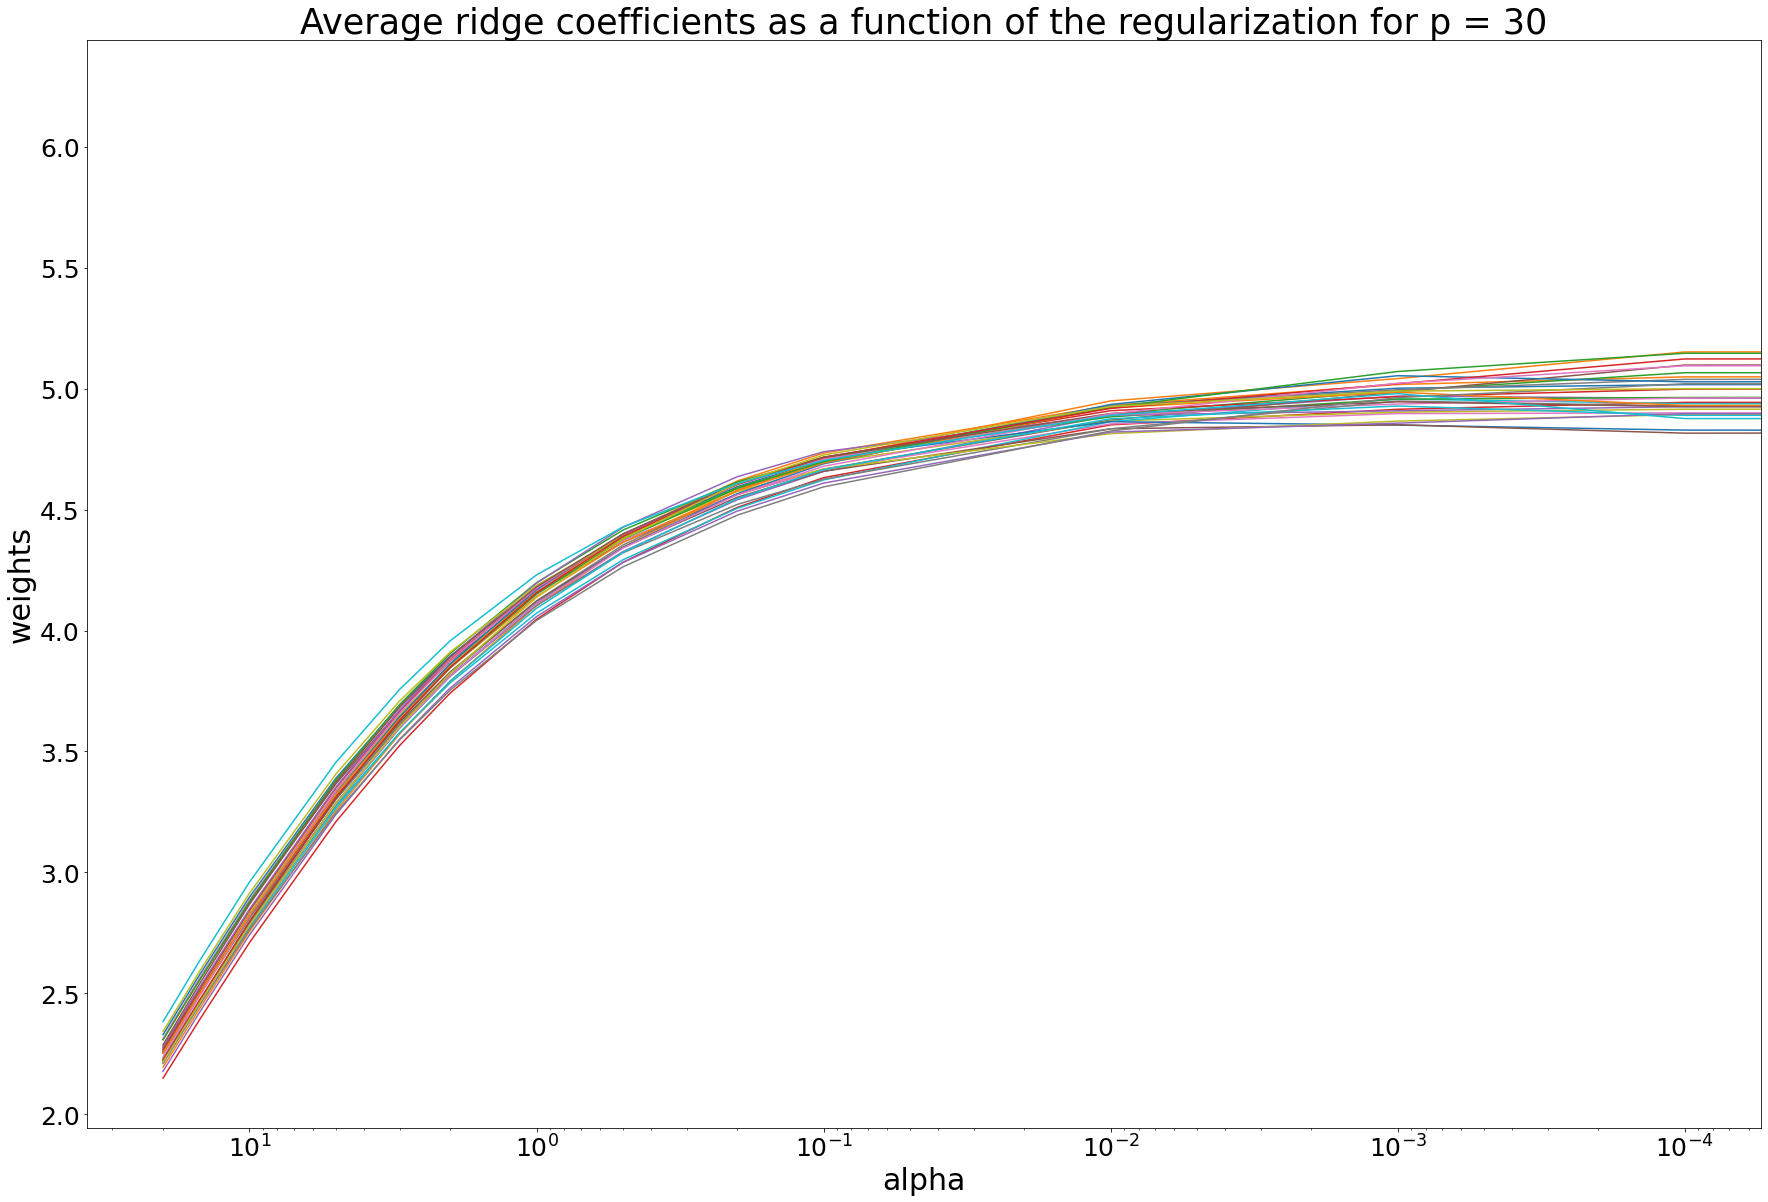

In [38]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_30)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 30", fontsize = 35)
plt.axis("tight")
plt.show()



In [54]:
alphas = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001]) 


df_list_betas_ridge_35, df_list_var_ridge_35 = iterate_ridge(n, 35, min_cor, max_cor, iterations_sim, alphas)

mean_df_list_betas_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_35) / iterations_sim
mean_df_list_var_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_35) / iterations_sim

mean_df_list_betas_ridge_35
mean_df_list_betas_ridge_35["alpha"] = alphas
mean_df_list_betas_ridge_35.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_35
    
mean_df_list_var_ridge_35
mean_df_list_var_ridge_35["alpha"] = alphas
mean_df_list_var_ridge_35.set_index("alpha", inplace = True)
mean_df_list_var_ridge_35

,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_26,beta_var_27,beta_var_28,beta_var_29,beta_var_30,beta_var_31,beta_var_32,beta_var_33,beta_var_34,beta_var_35
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,1.570331e+16,-1.818263e+17,-1.222133e+18,-9.922320e+16,4.932498e+16,1.393761e+16,1.356298e+16,-1.971899e+17,7.315311e+15,-5.844642e+16,...,-2.134703e+17,2.731564e+17,2.125281e+17,-2.631361e+17,-1.135470e+17,1.294666e+17,-1.223487e+17,3.552315e+17,-9.293385e+16,6.199047e+17
1.000000e-20,1.570331e+16,-1.818263e+17,-1.222133e+18,-9.922320e+16,4.932498e+16,1.393761e+16,1.356298e+16,-1.971899e+17,7.315311e+15,-5.844642e+16,...,-2.134703e+17,2.731564e+17,2.125281e+17,-2.631361e+17,-1.135470e+17,1.294666e+17,-1.223487e+17,3.552315e+17,-9.293385e+16,6.199047e+17
1.000000e-14,-4.141072e+12,-4.987360e+12,-4.308014e+12,-5.818358e+12,-4.157155e+12,-3.671841e+12,-4.840641e+12,-3.925372e+12,-4.104126e+12,-5.422598e+12,...,-8.199192e+12,-4.284764e+12,-4.067444e+12,-4.007622e+12,-4.897897e+12,-5.520041e+12,-3.843909e+12,-4.660459e+12,-4.821096e+12,-4.672377e+12
1.000000e-12,-2.842087e+05,-2.792708e+07,1.789365e+07,-6.353820e+06,-1.650287e+07,8.791060e+06,-3.764663e+06,-9.425444e+06,-1.457853e+07,-1.511432e+07,...,7.157147e+05,-4.538412e+06,-1.975693e+06,6.683399e+06,7.721355e+06,-1.491367e+07,-1.280924e+07,-4.570852e+06,-5.551074e+06,-4.524167e+06


In [55]:
mean_df_list_betas_ridge_35

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_26,beta_27,beta_28,beta_29,beta_30,beta_31,beta_32,beta_33,beta_34,beta_35
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,-169.250768,-309.744229,-266.103484,-68.105997,-33.422822,-106.036045,118.248197,167.542690,13.499634,74.235029,...,88.236600,47.937367,-70.329415,-74.840018,300.771069,69.888774,-33.693583,1.652595,-14.930585,23.085501
1.000000e-20,-169.250768,-309.744229,-266.103484,-68.105997,-33.422822,-106.036045,118.248197,167.542690,13.499634,74.235029,...,88.236600,47.937367,-70.329415,-74.840018,300.771069,69.888774,-33.693583,1.652595,-14.930585,23.085501
1.000000e-14,-6.583457,-0.062121,-11.222361,-2.073258,-6.733362,-1.833678,9.120595,18.231422,13.294960,10.522094,...,6.538567,26.375399,-17.371864,25.228976,9.788108,4.116285,4.391257,4.082972,4.019549,4.315282
1.000000e-12,4.282702,4.374623,4.272762,4.340061,4.321132,4.316829,4.266419,4.395456,4.298952,4.348240,...,4.335813,4.319232,4.219568,4.394470,4.328195,4.305922,4.208370,4.311207,4.186743,4.300312


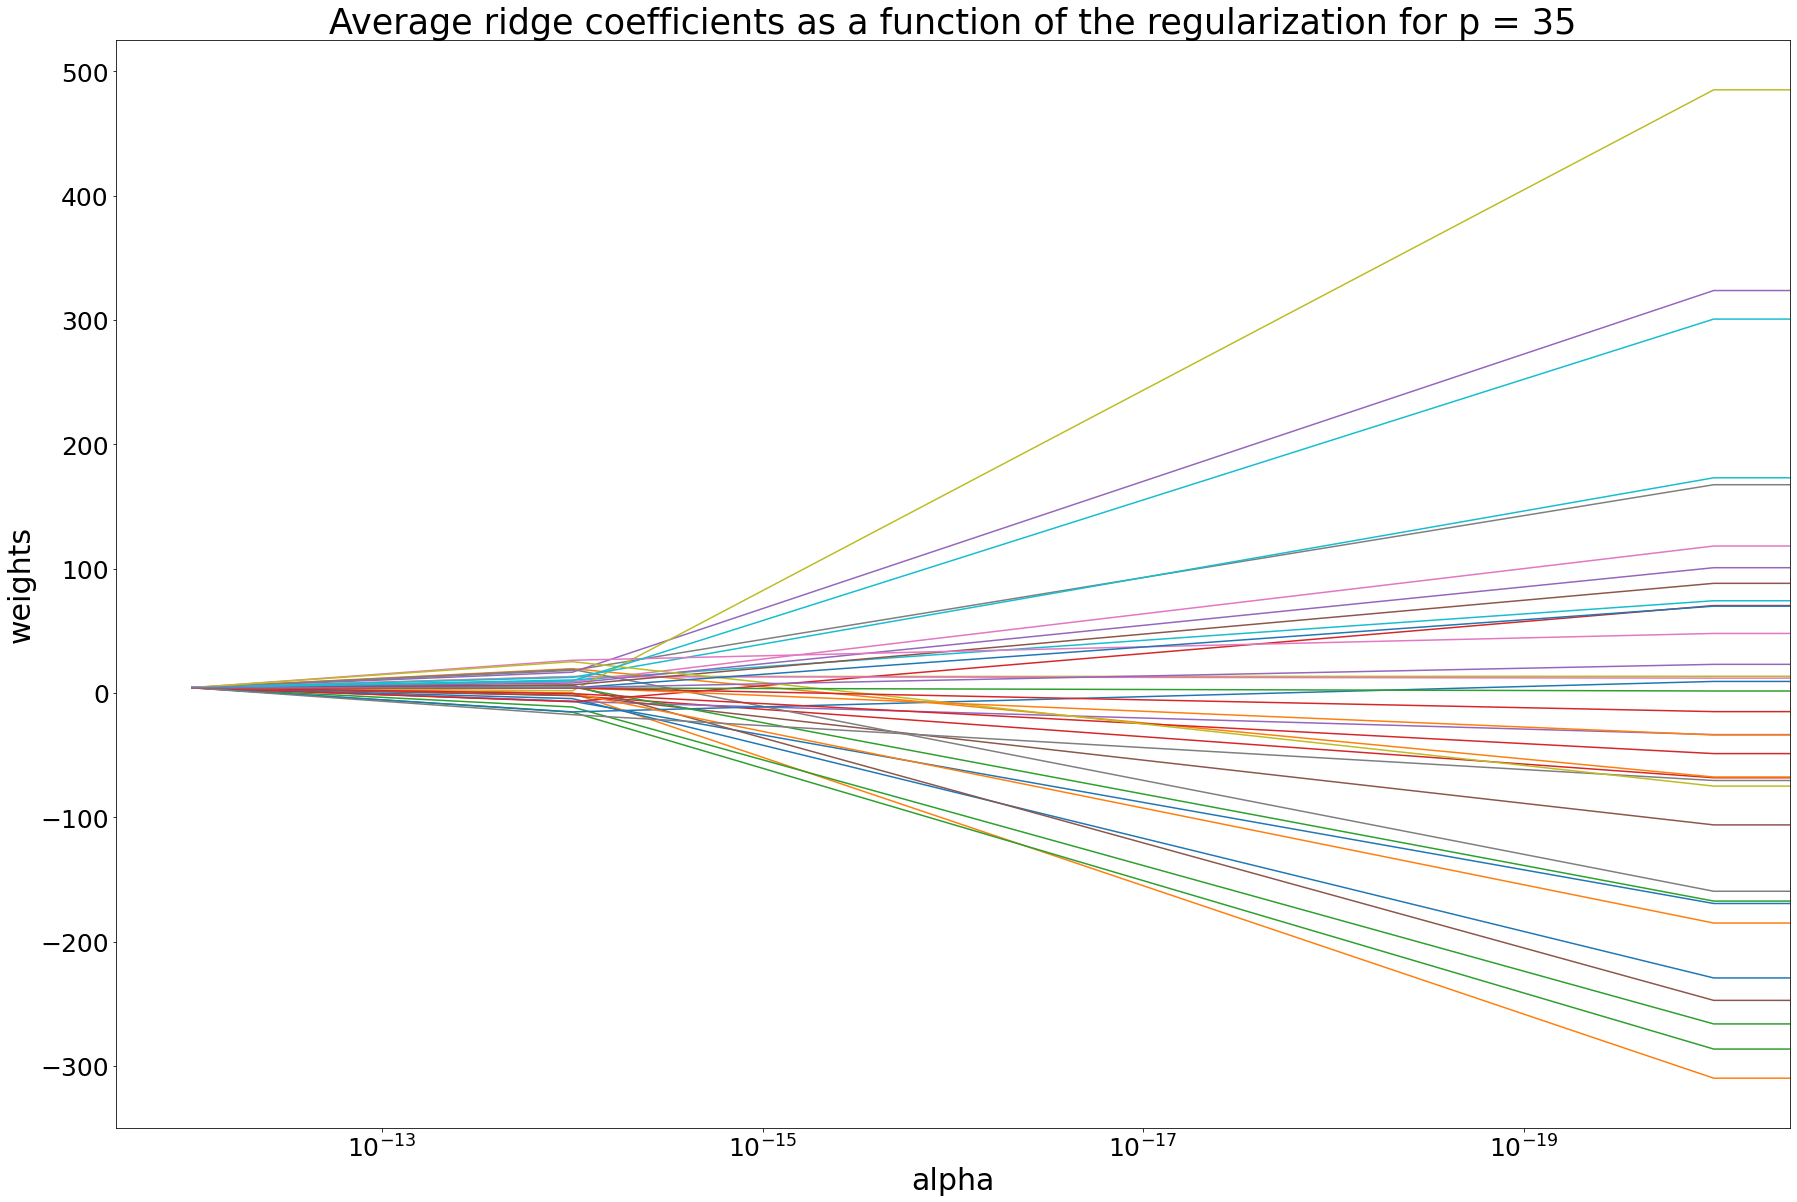

In [56]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_35)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)


plt.title("Average ridge coefficients as a function of the regularization for p = 35", fontsize = 35)
plt.axis("tight")
plt.show()




## Introduce Lasso for betas of size 5 as in ridge example. Show the characteristics of lasso. Then compare to ridge when betas are of similar magnitude and not close to zero. (for this phase we will use a test sample that we generate and compare MSEs)